In [1]:
%matplotlib inline
import math, random, warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise import accuracy
import time
from sklearn.externals import joblib
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Configure for any default setting of any library
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

### Read and explore the given dataset

In [3]:
electronics_ratings_df = pd.read_csv('ratings_Electronics.csv',names = ['userId', 'productId', 'ratings','timestamp'])

In [4]:
# Save an original copy of the dataframe
electronics_ratings_original_df = electronics_ratings_df.copy(deep=True)

In [5]:
electronics_ratings_df.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
electronics_ratings_df.tail(5)

,userId,productId,ratings,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


### Rename column/add headers, plot histograms,find data characteristics

In [7]:
electronics_ratings_df.shape

(7824482, 4)

In [8]:
electronics_ratings_df.drop('timestamp',inplace=True,axis=1)

In [9]:
electronics_ratings_df.shape

(7824482, 3)

In [10]:
unique_users = electronics_ratings_df['userId'].unique()
print("Unique users are",len(unique_users))

Unique users are 4201696


In [11]:
unique_products = electronics_ratings_df['productId'].unique()
print("Unique products are",len(unique_products))

Unique products are 476002


#### Ratings frequency count

In [12]:
electronics_ratings_value_counts = electronics_ratings_df['ratings'].value_counts().sort_index()
electronics_ratings_value_counts

1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347541
Name: ratings, dtype: int64

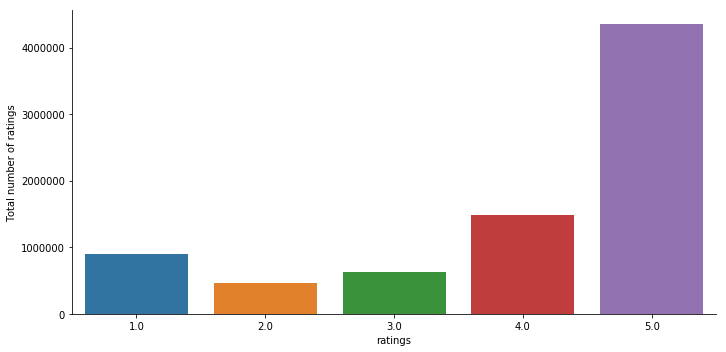

In [13]:
g = sns.factorplot("ratings", data=electronics_ratings_df, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")

#### From above plot we can see that rating category shows there is more frequency under rating 5 then rating 4 and then rating 1.
#### Users are rating mostly when they are satisfied or totally unsatisfied , average ratings is very less that is why rating 2 and tating 3 are less 

In [14]:
electronics_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [15]:
electronics_ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


### From Above we can see that Mean rating is 4.01 and Median rating is 5.0

In [16]:
electronics_ratings_df.isna().sum()

userId       0
productId    0
ratings      0
dtype: int64

>  There are no missing / null values

In [17]:
## Check if there are duplicate entries in the data
rating_combination = ['userId', 'productId']
electronics_ratings_df[electronics_ratings_df.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

,userId,productId,ratings


### There are no duplicates

In [18]:
# Find the unique products under each ratings
electronics_ratings_df.groupby('ratings')['productId'].nunique()

ratings
1.0    176283
2.0    123419
3.0    152827
4.0    223845
5.0    358458
Name: productId, dtype: int64

## Take a subset of the dataset to make it less sparse/ denser

In [19]:
ratings_counts=electronics_ratings_df['userId'].value_counts().rename_axis('userId').reset_index(name='ratings')
ratings_counts[:10]
print("These are the top 10 users based on number of ratings given")

,userId,ratings
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


These are the top 10 users based on number of ratings given


In [20]:
ratings_counts[-10:]
print("These are the last 10 users based on ratings given. These have given ratings only once ")

,userId,ratings
4201686,A3UALPMZ157V7Z,1
4201687,A1CI55DFLV6LE,1
4201688,A18ADSD3OOF7AC,1
4201689,A23KV2EPEKB5G5,1
4201690,A1YAAQ4WCH3ALW,1
4201691,A28STMXBTDQC2L,1
4201692,A1PZRZBOY4X8NV,1
4201693,A23NHKGPJQNQAK,1
4201694,AJF9TFCNLLY56,1
4201695,AJHYMVABKPTQ6,1


These are the last 10 users based on ratings given. These have given ratings only once 


#### if we have a user with only one rating ,we might be able to recommend some items but these recommendations might not be correct for that user.

In [21]:
ratings_counts.groupby('ratings')

### Users only who has given 50 or more number of ratings

In [22]:
#users_ratings_count = pd.DataFrame(electronics_ratings_df[['userId', 'ratings']].groupby('userId').count())
#well_rated_df = users_ratings_count[users_ratings_count.apply(lambda x: x['ratings'] >= 50, axis='columns')]

In [23]:
# Drop the users who have rated less than 50 products , Finding count user and items remaining
well_rated_electronics_ratings_df = electronics_ratings_df[electronics_ratings_df.userId.isin(ratings_counts[ratings_counts['ratings'] >= 50].userId)]
print('Users who have rated 50 or more products :', well_rated_electronics_ratings_df.userId.nunique())
print('Users dropped      :', electronics_ratings_df.userId.nunique() - well_rated_electronics_ratings_df.userId.nunique())
print('Items remaining    :', well_rated_electronics_ratings_df.productId.nunique())
print('Items dropped      :', electronics_ratings_df.productId.nunique() - well_rated_electronics_ratings_df.productId.nunique())

Users who have rated 50 or more products : 1540
Users dropped      : 4200156
Items remaining    : 48190
Items dropped      : 427812


In [24]:
print('\nFinal shape of the dataset :', well_rated_electronics_ratings_df.shape)


Final shape of the dataset : (125871, 3)


#### 1540 unique users with 50 or more ratings
#### This has made or dataset more dense

### Split the data randomly into train and test dataset

In [25]:
from sklearn.model_selection import train_test_split as train_test_split_sklearn
trainsetDf, testsetDf = train_test_split_sklearn(well_rated_electronics_ratings_df, test_size=.3,random_state=10)

In [26]:
print('Shape of the training set  :', trainsetDf.shape)
print('Shape of the test set      :', testsetDf.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


### Build Popularity Recommender model

#### Model 1 based on UserId count for each unique product , This method doesn't consider the the quality of the ratings recieved, rather just counts how many ratings are present for each product. 

In [27]:
# Get top - K ( K = 5) recommendations
def popularProducts(data,K = 5) : 
        agg_func=dict(userId='count')
        data_grouped = trainsetDf.groupby('productId').agg(agg_func).reset_index()
        data_grouped.rename(columns = {'userId': 'score'},inplace=True)
        #Sort based upon recommendation score
        data_sorted = data_grouped.sort_values(['score', 'productId'], ascending = [0,1])
        #Generate a recommendation rank based upon score
        data_sorted['Rank'] = data_sorted['score'].rank(ascending=0, method='first')

        #Get the top k recommendations
        return data_sorted.head(K)
        

In [28]:
topReccomendedProducts =popularProducts(trainsetDf)
topReccomendedProducts

,productId,score,Rank
30874,B0088CJT4U,142,1.0
19570,B003ES5ZUU,134,2.0
30273,B007WTAJTO,126,3.0
8700,B000N99BBC,117,4.0
30561,B00829TIEK,104,5.0


### Top five Trending or popular items are as above

In [29]:
# To suggest top 5 trending items to a particular user 
def recommendPopularItems(userId):
    print("%s User is reccomended below popular Items"%userId)
    topReccomendedProducts =popularProducts(trainsetDf)
    topReccomendedProducts['userId'] = userId
    return topReccomendedProducts

In [30]:
users = testsetDf['userId'].unique()

In [31]:
user_id = users[10]
recommendPopularItems(user_id)

A3VONQL7YW8UPM User is reccomended below popular Items


,productId,score,Rank,userId
30874,B0088CJT4U,142,1.0,A3VONQL7YW8UPM
19570,B003ES5ZUU,134,2.0,A3VONQL7YW8UPM
30273,B007WTAJTO,126,3.0,A3VONQL7YW8UPM
8700,B000N99BBC,117,4.0,A3VONQL7YW8UPM
30561,B00829TIEK,104,5.0,A3VONQL7YW8UPM


#### Model 2: sum of ratings for each unique product , this method will sum ratings for each product and then recommend products with highest sum. This model is better than Model 1. Producst with highest sum will be displayed first

In [32]:
# Get top - K ( K = 5) recommendations
def popularProductsM2(data,K = 5) : 
        agg_func=dict(ratings='sum')
        data_grouped = trainsetDf.groupby('productId').agg(agg_func).reset_index()
        data_grouped.rename(columns = {'ratings': 'score'},inplace=True)
        #Sort based upon recommendation score
        data_sorted = data_grouped.sort_values(['score', 'productId'], ascending = [0,1])
        #Generate a recommendation rank based upon score
        data_sorted['Rank'] = data_sorted['score'].rank(ascending=0, method='first')

        #Get the top k recommendations
        return data_sorted.head(K)
    
# To suggest top 5 trending items to a particular user 
def recommendPopularItemsM2(userId):
    print("%s User is reccomended below popular Items"%userId)
    topReccomendedProducts =popularProductsM2(trainsetDf)
    topReccomendedProducts['userId'] = userId
    return topReccomendedProducts
        

In [33]:
user_id = users[10]
recommendPopularItemsM2(user_id)

A3VONQL7YW8UPM User is reccomended below popular Items


,productId,score,Rank,userId
19570,B003ES5ZUU,652.0,1.0,A3VONQL7YW8UPM
30273,B007WTAJTO,594.0,2.0,A3VONQL7YW8UPM
30874,B0088CJT4U,591.0,3.0,A3VONQL7YW8UPM
8700,B000N99BBC,560.0,4.0,A3VONQL7YW8UPM
30561,B00829TIEK,460.0,5.0,A3VONQL7YW8UPM


### Build Collaborative Filtering model

#### Idea:
If a person A likes items 1, 2, 3 and B like 2,3,4 then they have similar interests and
A should like item
4 and B should like item 1.
This algorithm is entirely based on the past behavior and not on the context.
This makes it one of the
most commonly used algorithm as it is not dependent on any additional
information.

#### Basic assumptions:
- Customers who had similar tastes in the past, will have similar tastes in the future
- Users give ratings to catalog items (implicitly or explicitly) 


#### Examples : 
Product recommendations by e commerce player like Amazon and merchant recommendations by banks like
American Express.


#### Types of Collaborative Filtering (Nearest Neighborhood approach) : 
- Item Based Collaborative Filtering (IBCF)
    - Compute similarity between Items
- User Based Collaborative Filtering (UBCF)
    - Compute similarity between Users
    
Item Based Collaborative Filtering (IBCF) is more efficient than User Based Collaborative Filtering (UBCF) because Typical applications involve far more Users than Items.Similarity estimates between items is also more likely to converge over time than similarity between users. Hence the similarities can be pre computed and cached unlike similarity between users that need to be dynamically computed at every certain interval.

#### Matrix Factorization based Collaborative Filtering :
Identify latent (hidden) features from the input user x itemRatings matrix to represent users and items as vectors in N dimensional space.

Singular Value Decomposition (SVD)
Singular Value Decomposition (SVD) can be used to decompose any given Matrix, M into a product of 3 matrices as follows:$$M=U\times\sum\times{}V^T$$Where:

$U$: Left Singular Matrix
$V$: Right Singular Matrix
$\sum$: Diagonal Matrix of Latent Factors, and the values of the diagonal of $\sum$ are called the singular values
The matrix can be approximated to a lower rank by considering only the largest singular values.



In [34]:
### Due to memory issue considering only 25000 records, Since our rating scale is 1-5 which is also the default rating for Surprise reader package
from surprise import Reader, Dataset
reader = Reader()
surprise_ratings_df = Dataset.load_from_df(well_rated_electronics_ratings_df.head(25000), reader)

In [35]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(surprise_ratings_df, test_size=0.30,random_state=10)

In [36]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### Evaluating Item Based Collaborative Filtering (IBCF) model

In [37]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [38]:
# convert results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["was_impossible"] = [x["was_impossible"] for x in test_pred_df["details"]]
# Sort in descending order
test_pred_df.sort_values(by=['uid','est'], ascending=False, inplace=True)

In [39]:
test_pred_df.head()

,uid,iid,r_ui,est,details,was_impossible
6071,AZOK5STV85FBJ,B000GL3MOY,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",False
5792,AZOK5STV85FBJ,B00003006E,5.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",False
452,AZOK5STV85FBJ,B000EDMPQK,5.0,4.262114,"{'was_impossible': True, 'reason': 'User and/o...",True
674,AZOK5STV85FBJ,B000NNQO8Q,5.0,4.262114,"{'was_impossible': True, 'reason': 'User and/o...",True
2477,AZOK5STV85FBJ,B000CQQ092,3.0,4.262114,"{'was_impossible': True, 'reason': 'User and/o...",True


In [40]:
test_pred_df.tail()

,uid,iid,r_ui,est,details,was_impossible
2471,A100UD67AHFODS,B000OMKR8E,2.0,4.500000,"{'actual_k': 0, 'was_impossible': False}",False
6696,A100UD67AHFODS,B0002KVQBA,5.0,4.500000,"{'actual_k': 0, 'was_impossible': False}",False
518,A100UD67AHFODS,B00005T3X7,5.0,4.262114,"{'was_impossible': True, 'reason': 'User and/o...",True
503,A100UD67AHFODS,B000RYS3S0,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",False
6943,A100UD67AHFODS,B000J0072M,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",False


#### Algo is not able to find 5 neighbours for each user that is why se see "was_impossible': True" in some records, So we will filter these records

In [41]:
test_pred_df = test_pred_df.loc[~test_pred_df.was_impossible]
test_pred_df.head()

,uid,iid,r_ui,est,details,was_impossible
6071,AZOK5STV85FBJ,B000GL3MOY,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",False
5792,AZOK5STV85FBJ,B00003006E,5.0,4.333333,"{'actual_k': 0, 'was_impossible': False}",False
5415,AZNUHQSHZHSUE,B000N99BBC,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",False
921,AZNUHQSHZHSUE,B00006B7DA,5.0,4.602787,"{'actual_k': 1, 'was_impossible': False}",False
1907,AZMY6E8B52L2T,B000A0CV9S,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",False


### Item Based Collaborative Filtering (IBCF) - RMSE

In [42]:
print("Item Based Collaborative Filtering (IBCF) Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item Based Collaborative Filtering (IBCF) Model : Test Set
RMSE: 1.2177


1.2176561355430768

### Get top - K ( K = 5) recommendations - Popularity Recommender model¶

In [43]:
user_id = users[10]

In [44]:
#### Polularity based top 5 reccomendations
recommendPopularItemsM2(user_id)['productId']

A3VONQL7YW8UPM User is reccomended below popular Items


19570    B003ES5ZUU
30273    B007WTAJTO
30874    B0088CJT4U
8700     B000N99BBC
30561    B00829TIEK
Name: productId, dtype: object

### Item Based Collaborative Filtering (IBCF) model top 5 recommendations - Considering only those rows for which recommendation was possible

In [45]:
def collaborativeFilteringRecommendations(data,user_id,k=5):
    return data.loc[data['uid']==user_id]

In [46]:
collaborativeFilteringRecommendations(test_pred_df,user_id)

,uid,iid,r_ui,est,details,was_impossible
3603,A3VONQL7YW8UPM,B00000K3RI,4.0,3.0,"{'actual_k': 0, 'was_impossible': False}",False


In [47]:
#### For User A2XIOXRRYX0KZY there is only one recommendation as there are less than 5 neighbour

In [48]:
# Getting reccomendations for different users
user_id2 = users[15]
collaborativeFilteringRecommendations(test_pred_df,user_id2)

,uid,iid,r_ui,est,details,was_impossible
2744,A2NB2E5DXE319Z,B000I30HOS,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",False
3578,A2NB2E5DXE319Z,B000N99BBC,5.0,4.756303,"{'actual_k': 1, 'was_impossible': False}",False
801,A2NB2E5DXE319Z,B000AZ57M6,5.0,4.714286,"{'actual_k': 1, 'was_impossible': False}",False
1560,A2NB2E5DXE319Z,B0002UB2P0,5.0,4.500000,"{'actual_k': 0, 'was_impossible': False}",False


### User Based Collaborative Filtering (UBCF) model

In [51]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo_ubcf = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_ubcf.fit(trainset)
# run the trained model against the testset
test_pred_ubcf = algo_ubcf.test(testset)
# convert results to dataframe
test_pred_ubcf_df = pd.DataFrame(test_pred_ubcf)
test_pred_ubcf_df["was_impossible"] = [x["was_impossible"] for x in test_pred_ubcf_df["details"]]
# Sort in descending order
test_pred_ubcf_df.sort_values(by=['uid','est'], ascending=False, inplace=True)
test_pred_ubcf_df = test_pred_ubcf_df.loc[~test_pred_ubcf_df.was_impossible]
test_pred_ubcf_df.head()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,uid,iid,r_ui,est,details,was_impossible
5792,AZOK5STV85FBJ,B00003006E,5.0,4.722222,"{'actual_k': 0, 'was_impossible': False}",False
6071,AZOK5STV85FBJ,B000GL3MOY,5.0,4.722222,"{'actual_k': 0, 'was_impossible': False}",False
921,AZNUHQSHZHSUE,B00006B7DA,5.0,4.222222,"{'actual_k': 0, 'was_impossible': False}",False
5415,AZNUHQSHZHSUE,B000N99BBC,5.0,4.222222,"{'actual_k': 0, 'was_impossible': False}",False
1621,AZMY6E8B52L2T,B000ANOY7M,5.0,4.916667,"{'actual_k': 0, 'was_impossible': False}",False


### Evaluating RMSE User Based Collaborative Filtering (UBCF) model

In [52]:
print("Item Based Collaborative Filtering (IBCF) Model : Test Set")
accuracy.rmse(test_pred_ubcf, verbose=True)

Item Based Collaborative Filtering (IBCF) Model : Test Set
RMSE: 1.1254


1.1254314554102391

#### Top 5 Recommendation using User Based approach

In [53]:
collaborativeFilteringRecommendations(test_pred_ubcf_df,user_id2)

,uid,iid,r_ui,est,details,was_impossible
801,A2NB2E5DXE319Z,B000AZ57M6,5.0,4.684211,"{'actual_k': 0, 'was_impossible': False}",False
1560,A2NB2E5DXE319Z,B0002UB2P0,5.0,4.684211,"{'actual_k': 0, 'was_impossible': False}",False
2744,A2NB2E5DXE319Z,B000I30HOS,5.0,4.684211,"{'actual_k': 0, 'was_impossible': False}",False
3578,A2NB2E5DXE319Z,B000N99BBC,5.0,4.684211,"{'actual_k': 0, 'was_impossible': False}",False


In [54]:
collaborativeFilteringRecommendations(test_pred_ubcf_df,user_id)

,uid,iid,r_ui,est,details,was_impossible
3603,A3VONQL7YW8UPM,B00000K3RI,4.0,3.857143,"{'actual_k': 0, 'was_impossible': False}",False


### Matrix Factorization based Collaborative Filtering SVD Model 

In [55]:
from surprise import SVD
algo = SVD()
algo.fit(trainset)

In [56]:
predictions = algo.test(testset)

In [57]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [58]:
top_n = get_top_n(predictions, n=5)

In [59]:
top_n['A6VPK7X53QNAQ']

[('B000RZNI4S', 4.615146016794938),
 ('B000HDQ2G6', 4.614668550569081),
 ('B000G18DR0', 4.6140566141728065),
 ('B00003G1RG', 4.526906465563579),
 ('B000IF51UQ', 4.507517722538404)]

In [60]:
print("SVD Model : Test Set")
accuracy.rmse(predictions, verbose=True)

SVD Model : Test Set
RMSE: 1.0712


1.0711828106384205

#### We can tune algorithm parameters with GridSearchCV

In [61]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(surprise_ratings_df)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.066061943482858
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


### Summarise your insights

> The collaborative filtering model is more personalized than the popularity based model.

> <b>Popularity based reccomendations :</b> The products with highest number of ratings sum gets recommended irrespective of user's interest i.e shows same recommendations to all the user. This is the model used as a basic recommendation even when the user is not even logged into Amazon.

> Collaborative filtering gives a more personalised recommendations as opposed to popularity based.
<b>Collaborative Filtering</b> based model has recommended entire different list based on the user past purchase history.

> SVD has lower RMSE than Item - Item  and User - Item similarity model